<a href="https://colab.research.google.com/github/HUMINTING/callte-detetion-detail/blob/main/torch_retinanet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
 !git clone https://github.com/fizyr/keras-retinanet.git

Cloning into 'keras-retinanet'...
remote: Enumerating objects: 6224, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 6224 (delta 6), reused 9 (delta 2), pack-reused 6205
Receiving objects: 100% (6224/6224), 13.48 MiB | 15.98 MiB/s, done.
Resolving deltas: 100% (4207/4207), done.


In [ ]:
 !pip install torch torchvision

In [ ]:
import torch
import torchvision
from torchvision.models.detection import retinanet_resnet50_fpn


In [ ]:
model = retinanet_resnet50_fpn(pretrained=True)
model.eval()

if torch.cuda.is_available():
    model = model.cuda()


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RetinaNet_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=RetinaNet_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/retinanet_resnet50_fpn_coco-eeacb38b.pth" to /root/.cache/torch/hub/checkpoints/retinanet_resnet50_fpn_coco-eeacb38b.pth
100%|██████████| 130M/130M [00:01<00:00, 72.9MB/s]


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models.detection import retinanet_resnet50_fpn
from PIL import Image
import os
import xml.etree.ElementTree as ET
import random


class VOCDataset(Dataset):
    def __init__(self, root, image_set='train', transform=None):
        self.root = root
        self.image_set = image_set
        self.transform = transform

        self._image_dir = os.path.join(self.root, "JPEGImages")
        self._annotation_dir = os.path.join(self.root, "Annotations")

        image_set_file = os.path.join(self.root, "ImageSets", "Main", f"{self.image_set}.txt")
        with open(image_set_file, "r") as f:
            self.ids = [x.strip() for x in f.readlines()]

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, index):
        img_id = self.ids[index]
        img_path = os.path.join(self._image_dir, f"{img_id}.jpg")
        annotation_path = os.path.join(self._annotation_dir, f"{img_id}.xml")

        img = Image.open(img_path).convert("RGB")
        target = self.parse_voc_annotation(annotation_path)

        if self.transform:
            img, target = self.transform(img, target)

        return img, target

    def parse_voc_annotation(self, path):
        tree = ET.parse(path)
        root = tree.getroot()

        boxes = []
        labels = []
        class_to_id = {"standing_all": 1, "standing": 2}

        for obj in root.findall("object"):
            bbox = obj.find("bndbox")
            bbox = [int(bbox.find("xmin").text), int(bbox.find("ymin").text),
                    int(bbox.find("xmax").text), int(bbox.find("ymax").text)]
            boxes.append(bbox)
            labels.append(class_to_id[obj.find("name").text])

        if len(boxes) == 0:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros(0, dtype=torch.int64)
        else:
            boxes = torch.tensor(boxes, dtype=torch.float32)
            labels = torch.tensor(labels)

        return {"boxes": boxes, "labels": labels}


class NewTransform:
    def __init__(self):
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    def __call__(self, img, target):
        img, target = self.random_horizontal_flip(img, target)
        img = transforms.ToTensor()(img)
        img = self.normalize(img)
        return img, target

    def random_horizontal_flip(self, img, target, prob=0.5):
        if random.random() < prob:
            img = transforms.functional.hflip(img)
            width, _ = img.size
            boxes = target["boxes"]

            if boxes.nelement() > 0:
                boxes[:, [0, 2]] = width - boxes[:, [2, 0]]
                target["boxes"] = boxes

        return img, target


def collate_fn(batch):
    return tuple(zip(*batch))


# Data loading
transform = NewTransform()
train_dataset = VOCDataset(root="/content/drive/MyDrive/new_estrus/yolo/train_voc", image_set="train", transform=transform)
val_dataset = VOCDataset(root="/content/drive/MyDrive/new_estrus/yolo/val_voc", image_set="val", transform=transform)


train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn, num_workers=4)

# Model and training
model = retinanet_resnet50_fpn(pretrained=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)

model.train()
num_epochs = 10
for epoch in range(num_epochs):
    for images, targets in train_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    # Save model after each epoch (optional)
    torch.save(model.state_dict(), f"model_epoch_{epoch}.pth")

print("Training finished.")


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RetinaNet_ResNet50_FPN_Weights.COCO_V1`. You

KeyboardInterrupt: ignored

In [ ]:
!mv /content/model_epoch_*.pth /content/drive/MyDrive/mt_detection/20231022/troch


In [ ]:
print(prediction['labels'], prediction['scores'])


tensor([], device='cuda:0', dtype=torch.int64) tensor([], device='cuda:0')


In [ ]:
import json

# 加载COCO注释文件
with open('/content/drive/MyDrive/new_estrus/yolo/train_coco.json', 'r') as f:
    data = json.load(f)

# 确保基础结构存在
assert 'images' in data, "'images' key missing"
assert 'annotations' in data, "'annotations' key missing"
assert 'categories' in data, "'categories' key missing"

# 获取所有图像ID和注释ID
image_ids = [img['id'] for img in data['images']]
annotation_image_ids = [ann['image_id'] for ann in data['annotations']]

# 确保每个注释都有一个对应的图像
for ann_image_id in annotation_image_ids:
    assert ann_image_id in image_ids, f"No image found for annotation with image_id {ann_image_id}"

# 对于每个注释, 检查边界框坐标
for ann in data['annotations']:
    x, y, w, h = ann['bbox']
    assert w > 0 and h > 0, f"Invalid bbox dimensions for annotation id {ann['id']}"

# 检查类别标签
category_ids = [cat['id'] for cat in data['categories']]
for ann in data['annotations']:
    assert ann['category_id'] in category_ids, f"Invalid category_id {ann['category_id']} for annotation id {ann['id']}"

print("Annotation file looks good!")


Annotation file looks good!


In [ ]:
import json

# 加载COCO标注文件
with open('/content/drive/MyDrive/new_estrus/yolo/train_coco.json', 'r') as f:
    data = json.load(f)

image_ids = {image['id'] for image in data['images']}
annotation_image_ids = {annotation['image_id'] for annotation in data['annotations']}
# 查找没有标注的图像id
images_without_annotations = image_ids - annotation_image_ids

print(f"Total number of images: {len(image_ids)}")
print(f"Number of images with annotations: {len(annotation_image_ids)}")
print(f"Number of images without annotations: {len(images_without_annotations)}")

if images_without_annotations:
    print("Image IDs without annotations:", images_without_annotations)



Total number of images: 3585
Number of images with annotations: 2372
Number of images without annotations: 1213
Image IDs without annotations: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 1

In [ ]:
invalid_boxes = []

for anno in data['annotations']:
    x, y, w, h = anno['bbox']

    # 这里我们只检查宽度和高度，但你也可以根据需要添加其他条件。
    if w <= 0 or h <= 0:
        invalid_boxes.append(anno)

print(f"Number of invalid boxes: {len(invalid_boxes)}")


Number of invalid boxes: 0


In [ ]:
image_id_to_size = {img['id']: (img['width'], img['height']) for img in data['images']}

for anno in data['annotations']:
    x, y, w, h = anno['bbox']
    img_width, img_height = image_id_to_size[anno['image_id']]

    if x + w > img_width or y + h > img_height:
        invalid_boxes.append(anno)

print(f"Number of boxes outside image bounds: {len(invalid_boxes)}")


Number of boxes outside image bounds: 2


In [ ]:
for box in invalid_boxes:
    print(box)


{'id': 3435, 'image_id': 2930, 'category_id': 2, 'bbox': [351, 463, 907, 618], 'area': 560526, 'iscrowd': 0, 'segmentation': []}
{'id': 3805, 'image_id': 3115, 'category_id': 1, 'bbox': [437, 379, 832, 703], 'area': 584896, 'iscrowd': 0, 'segmentation': []}


In [ ]:
print("Image ID 2930 size:", image_id_to_size[2930])
print("Image ID 3115 size:", image_id_to_size[3115])


Image ID 2930 size: (1920, 1080)
Image ID 3115 size: (1920, 1080)


In [ ]:
import json

# 读取原始标注数据
with open('/content/drive/MyDrive/new_estrus/yolo/train_coco.json', 'r') as f:
    data = json.load(f)

# 找到并删除相关的边界框
invalid_box_ids = [3435, 3805]  # 根据您提供的信息，这是两个无效框的ID
data['annotations'] = [anno for anno in data['annotations'] if anno['id'] not in invalid_box_ids]

# 将修改后的数据保存回JSON文件
with open('/content/drive/MyDrive/new_estrus/yolo/train_coco_cleaned.json', 'w') as f:
    json.dump(data, f)

print("Invalid boxes have been removed!")


Invalid boxes have been removed!


In [44]:
import torch
import torchvision
from torchvision.models.detection import retinanet_resnet50_fpn

# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# 类别数
num_classes = 3  # 2 classes + background

# 加载模型

# 1. 不使用预训练权重加载模型
model = retinanet_resnet50_fpn(pretrained=False, num_classes=num_classes)
model = model.to(device)

# 2. 加载预训练权重并移除分类头的权重
pretrained_weights = torchvision.models.detection.retinanet_resnet50_fpn(pretrained=True).state_dict()
pretrained_weights = {k: v for k, v in pretrained_weights.items() if not k.startswith("head.classifier")}
# 移除与分类相关的权重
keys_to_remove = ["head.classification_head.cls_logits.weight", "head.classification_head.cls_logits.bias"]
for key in keys_to_remove:
    if key in pretrained_weights:
        del pretrained_weights[key]

# 3. 使用修改后的权重初始化模型
model.load_state_dict(pretrained_weights, strict=False)


# 数据加载
from torchvision.datasets import CocoDetection
import torchvision.transforms as transforms


transform = transforms.Compose([
    #transforms.Resize((640, 640)),  # 这将调整图像的大小为800x800，你可以根据需要修改这个尺寸
    transforms.ToTensor()
])

# 训练数据
train_data = CocoDetection(root='/content/drive/MyDrive/new_estrus/yolo/train_coco',
                           annFile='/content/drive/MyDrive/new_estrus/yolo/train_coco.json',
                           transform=transform)



# 验证数据
val_data = CocoDetection(root='/content/drive/MyDrive/new_estrus/yolo/val_coco',
                         annFile='/content/drive/MyDrive/new_estrus/yolo/val_coco.json',
                         transform=transform)

def collate_fn(batch):
    images, annotations = zip(*batch)

    targets = []
    for idx, anno in enumerate(annotations):
        target = {}

        if not anno:
            target['boxes'] = torch.zeros((0, 4), dtype=torch.float32)
            target['labels'] = torch.zeros((0,), dtype=torch.int64)
        else:
            boxes = []
            labels = []
            for item in anno:
                x, y, w, h = item['bbox']

                # Ensure positive width and height
                if w < 0:
                    x = x + w
                    w = -w
                if h < 0:
                    y = y + h
                    h = -h

                # Convert to [x1, y1, x2, y2] format
                x1 = x
                y1 = y
                x2 = x + w
                y2 = y + h

                # Clip the bounding box coordinates
              # Clip the bounding box coordinates based on the original image size
                x1 = min(max(x1, 0), 1919.9)
                y1 = min(max(y1, 0), 1079.9)
                x2 = min(max(x2, 0), 1919.9)
                y2 = min(max(y2, 0), 1079.9)


                # Exclude invalid boxes
                if (x2 - x1) > 0 and (y2 - y1) > 0:
                    boxes.append([x1, y1, x2, y2])
                    labels.append(item['category_id'])
                else:
                    print(f"Excluding invalid box: {[x1, y1, x2, y2]} at index {idx}")
            target['boxes'] = torch.FloatTensor(boxes).reshape(-1, 4)  # Ensure the shape is [N, 4]
            target['labels'] = torch.LongTensor(labels)


        targets.append(target)

    return list(images), targets




train_loader = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=4, shuffle=False, collate_fn=collate_fn)

# 优化器和损失
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)

# 训练和验证函数
from torch.nn.utils import clip_grad_norm_

def train_one_epoch(model, optimizer, data_loader, device):
    model.train()
    total_loss = 0
    for batch_idx, (images, targets) in enumerate(data_loader):
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()

        # 梯度裁剪
        clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        total_loss += losses.item()

        # 打印每个批次的损失
        #print(f"Batch {batch_idx+1}/{len(data_loader)} - Loss: {losses.item()}")

        # 打印损失字典的每个组件
        #for loss_name, loss_value in loss_dict.items():
            #print(f"    {loss_name}: {loss_value.item()}")

        # 检查损失是否为nan
        if torch.isnan(losses):
            print("NAN loss detected!")
            for idx, img in enumerate(images):
                # 这里只是为了说明，您可能需要一个更合适的方法来保存或显示图像
                torchvision.utils.save_image(img, f"nan_image_{batch_idx}_{idx}.png")
            # 打印此批次的标注
            print(targets)

    return total_loss / len(data_loader)

"""def evaluate(model, data_loader, device):
    model.eval()
    total_loss = 0
    criterion = torchvision.models.detection._utils.RetinaNetLossComputation(
        num_classes=num_classes
    )

    with torch.no_grad():
        for images, targets in data_loader:
            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Get model predictions
            predictions = model(images)

            # Compute the loss
            loss_dict = criterion(predictions, targets)
            losses = sum(loss for loss in loss_dict.values())

            total_loss += losses.item()

    return total_loss / len(data_loader)
"""



"""def evaluate(model, data_loader, device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for images, targets in data_loader:
            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # 直接获取模型的损失
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            total_loss += losses.item()

    return total_loss / len(data_loader)"""
def evaluate(model, data_loader, device):
    model.train()  # 注意这里，我们仍然使用训练模式
    total_loss = 0

    with torch.no_grad():  # 禁止梯度计算
        for images, targets in data_loader:
            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            total_loss += losses.item()

    return total_loss / len(data_loader)


# 主训练循环
num_epochs = 20
for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, optimizer, train_loader, device)
    val_loss = evaluate(model, val_loader, device)
    print(f"Epoch {epoch+1}/{num_epochs} - Training Loss: {train_loss}, Validation Loss: {val_loss}")

# 保存模型
torch.save(model.state_dict(), '/content/drive/MyDrive/mt_detection/20231022/troch/retinanet_epoch20.pth')

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.17s)
creating index...
index created!
Epoch 1/20 - Training Loss: 1.71320715170458, Validation Loss: 1.0617863897130722
Epoch 2/20 - Training Loss: 1.0010982219729982, Validation Loss: 1.0264439443042244
Epoch 3/20 - Training Loss: 0.9209008522593163, Validation Loss: 0.8930781634408049
Epoch 4/20 - Training Loss: 0.8456973681366085, Validation Loss: 0.8793603602658389
Epoch 5/20 - Training Loss: 0.8113670080548383, Validation Loss: 0.8373520876147733
Epoch 6/20 - Training Loss: 0.7950046650985273, Validation Loss: 0.804946017922355
Epoch 7/20 - Training Loss: 0.7690598073492776, Validation Loss: 0.842446814687056
Epoch 8/20 - Training Loss: 0.7562176276220137, Validation Loss: 0.8885866161750164
Epoch 9/20 - Training Loss: 0.7261001016364874, Validation Loss: 0.7643885531987892
Epoch 10/20 - Training Loss: 0.7229013037400138, Validation Loss: 0.98798529387956

KeyboardInterrupt: ignored

In [49]:
# 加载模型
model_path = '/content/drive/MyDrive/mt_detection/20231022/troch/retinanet_epoch10.pth'
model.load_state_dict(torch.load(model_path))
model = model.to(device)
model.eval()

# 定义阈值
confidence_threshold = 0.5

TP = 0
TN = 0
FP = 0
FN = 0

with torch.no_grad():
    for images, targets in val_loader:
        images = [image.to(device) for image in images]

        # 获取模型预测
        predictions = model(images)

        for i, prediction in enumerate(predictions):
            true_labels = targets[i]['labels'].cpu().numpy()

            # 检查图像中是否有标签为 'standing_all' 或 'standing'
            #has_positive_label = any(label in [1, 2] for label in true_labels)
            has_both_labels = all(label in true_labels for label in [1, 2])

            # 预测的 boxes 和 labels
            pred_boxes = prediction['boxes'].cpu().numpy()
            pred_labels = prediction['labels'].cpu().numpy()
            pred_scores = prediction['scores'].cpu().numpy()

            # 根据 confidence_threshold 进行筛选
            selected_preds = pred_scores > confidence_threshold
            filtered_pred_labels = pred_labels[selected_preds]

            # 检查是否有预测为 'standing_all' 或 'standing' 的标签

            #has_positive_prediction = any(label in [1, 2] for label in filtered_pred_labels)
            has_both_predictions = all(label in filtered_pred_labels for label in [1, 2])

            # 计算 TP, TN, FP, FN
            if has_both_labels and has_both_predictions:
                TP += 1
            elif not has_both_labels and not has_both_predictions:
                TN += 1
            elif not has_both_labels and has_both_predictions:
                FP += 1
            elif has_both_labels and not has_both_predictions:
                FN += 1

print(f"True Positives: {TP}")
print(f"True Negatives: {TN}")
print(f"False Positives: {FP}")
print(f"False Negatives: {FN}")


True Positives: 425
True Negatives: 304
False Positives: 1
False Negatives: 168


In [45]:
# 加载模型
model_path = '/content/drive/MyDrive/mt_detection/20231022/troch/retinanet_epoch10.pth'
model.load_state_dict(torch.load(model_path))
model = model.to(device)
model.eval()

# 定义阈值
confidence_threshold = 0.5

# 初始化统计量
TP_class_1 = 0
TN_class_1 = 0
FP_class_1 = 0
FN_class_1 = 0

TP_class_2 = 0
TN_class_2 = 0
FP_class_2 = 0
FN_class_2 = 0

with torch.no_grad():
    for images, targets in val_loader:
        images = [image.to(device) for image in images]

        # 获取模型预测
        predictions = model(images)

        for i, prediction in enumerate(predictions):
            true_labels = targets[i]['labels'].cpu().numpy()

            # 预测的 boxes 和 labels
            pred_boxes = prediction['boxes'].cpu().numpy()
            pred_labels = prediction['labels'].cpu().numpy()
            pred_scores = prediction['scores'].cpu().numpy()

            # 根据 confidence_threshold 进行筛选
            selected_preds = pred_scores > confidence_threshold
            filtered_pred_labels = pred_labels[selected_preds]

            # 类别1的评估
            is_true_positive_1 = 1 in true_labels and 1 in filtered_pred_labels
            is_true_negative_1 = 1 not in true_labels and 1 not in filtered_pred_labels
            is_false_positive_1 = 1 not in true_labels and 1 in filtered_pred_labels
            is_false_negative_1 = 1 in true_labels and 1 not in filtered_pred_labels

            TP_class_1 += is_true_positive_1
            TN_class_1 += is_true_negative_1
            FP_class_1 += is_false_positive_1
            FN_class_1 += is_false_negative_1

            # 类别2的评估
            is_true_positive_2 = 2 in true_labels and 2 in filtered_pred_labels
            is_true_negative_2 = 2 not in true_labels and 2 not in filtered_pred_labels
            is_false_positive_2 = 2 not in true_labels and 2 in filtered_pred_labels
            is_false_negative_2 = 2 in true_labels and 2 not in filtered_pred_labels

            TP_class_2 += is_true_positive_2
            TN_class_2 += is_true_negative_2
            FP_class_2 += is_false_positive_2
            FN_class_2 += is_false_negative_2

print("Class 1 - TP:", TP_class_1)
print("Class 1 - TN:", TN_class_1)
print("Class 1 - FP:", FP_class_1)
print("Class 1 - FN:", FN_class_1)

print("\nClass 2 - TP:", TP_class_2)
print("Class 2 - TN:", TN_class_2)
print("Class 2 - FP:", FP_class_2)
print("Class 2 - FN:", FN_class_2)

precision_class_1 = TP_class_1 / (TP_class_1 + FP_class_1)
recall_class_1 = TP_class_1 / (TP_class_1 + FN_class_1)

precision_class_2 = TP_class_2 / (TP_class_2 + FP_class_2)
recall_class_2 = TP_class_2 / (TP_class_2 + FN_class_2)

print("\nClass 1 - Precision:", precision_class_1)
print("Class 1 - Recall:", recall_class_1)

print("\nClass 2 - Precision:", precision_class_2)
print("Class 2 - Recall:", recall_class_2)


Class 1 - TP: 438
Class 1 - TN: 304
Class 1 - FP: 0
Class 1 - FN: 156

Class 2 - TP: 472
Class 2 - TN: 304
Class 2 - FP: 1
Class 2 - FN: 121

Class 1 - Precision: 1.0
Class 1 - Recall: 0.7373737373737373

Class 2 - Precision: 0.9978858350951374
Class 2 - Recall: 0.7959527824620574


In [ ]:
!pip install matplotlib


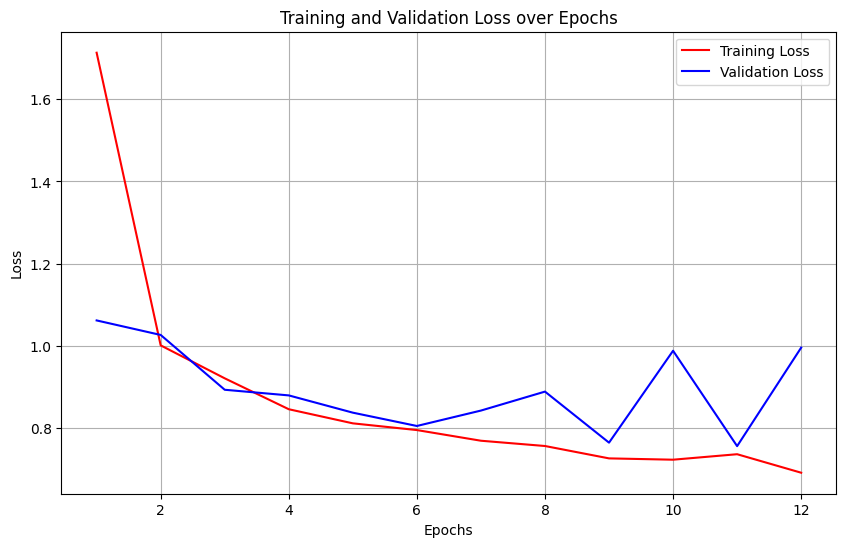

In [46]:
import matplotlib.pyplot as plt

# 定义训练和验证损失
epochs = list(range(1, 13))
training_loss = [1.71320715170458, 1.0010982219729982, 0.9209008522593163, 0.8456973681366085, 0.8113670080548383, 0.7950046650985273, 0.7690598073492776, 0.7562176276220137, 0.7261001016364874, 0.7229013037400138, 0.7362359914961737, 0.6912074137474102]
validation_loss = [1.0617863897130722, 1.0264439443042244, 0.8930781634408049, 0.8793603602658389, 0.8373520876147733, 0.804946017922355, 0.842446814687056, 0.8885866161750164, 0.7643885531987892, 0.9879852938795618, 0.7559076537238434, 0.9956172222501158]

# 创建图表
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, 'r', label='Training Loss')
plt.plot(epochs, validation_loss, 'b', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()
